In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# prompt: ZIP File extraction

import zipfile
import os

# Assuming the zip file is in your Google Drive
# Replace 'path/to/your/zipfile.zip' with the actual path in your Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/ChestXRay2017.zip'
extract_path = '/content/extracted_zip' # Directory to extract to in Colab

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Zip file extracted to: {extract_path}")

# Optional: List the contents of the extracted directory
# print(os.listdir(extract_path))

Zip file extracted to: /content/extracted_zip


In [8]:
import os
print(os.listdir('/content/extracted_zip'))

['__MACOSX', 'chest_xray']


In [9]:
# prompt: # Path to foots piece images

zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
img_size = (224, 224)
batch_size = 32
seed = 42

In [16]:
import os

extracted_path = '/content/extracted_zip/chest_xray'
if os.path.exists(extracted_path):
    print(os.listdir(extracted_path))
else:
    print(f"Directory not found: {extracted_path}")

['.DS_Store', 'train', 'test']


In [27]:
# prompt: # Load full dataset


dataset_path = os.path.join(extract_path, 'chest_xray') # Corrected dataset path

# Define paths for training, validation, and test sets
train_dir = os.path.join(dataset_path, 'train') # Corrected directory name
valid_dir = os.path.join(dataset_path, 'test') # Corrected directory name
test_dir = os.path.join(dataset_path, 'test') # Corrected directory name

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Training directory not found: {train_dir}")
if not os.path.exists(valid_dir):
    print(f"Validation directory not found: {valid_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory not found: {test_dir}")


# Data Augmentation and Rescaling for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only Rescaling for Validation and Test Data
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed,
    shuffle=False # Keep data in order for evaluation
)

print("Data loaded successfully.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {valid_generator.samples} validation images belonging to {valid_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

# Get the class names
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data loaded successfully.
Found 5232 training images belonging to 2 classes.
Found 624 validation images belonging to 2 classes.
Found 624 test images belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


In [18]:
# prompt: Build the CNN Model

# Build the CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,475,010 (196.36 MB)

 Trainable params: 51,475,010 (196.36 MB)

 Non-trainable params: 0 (0.00 B)

Sample Training Images:


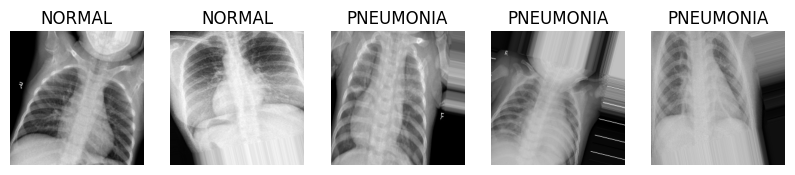


Sample Validation Images:


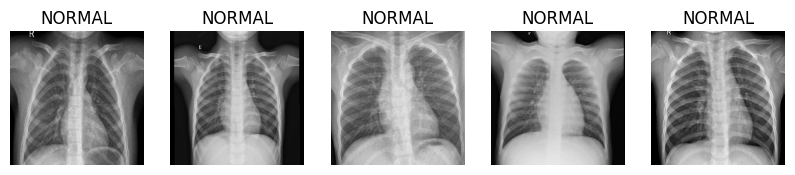


Sample Test Images:


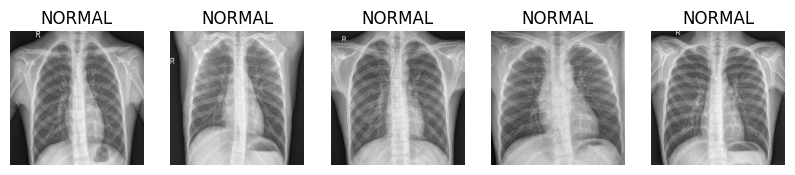

In [21]:
# prompt: # Show Images

import matplotlib.pyplot as plt
import numpy as np
# Function to display sample images
def show_images(generator, num_images=5):
  """
  Displays a batch of images from the generator along with their labels.
  """
  images, labels = next(generator) # Get a batch of images and labels

  plt.figure(figsize=(10, 10))
  for i in range(min(num_images, images.shape[0])):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    # Get the class name from the one-hot encoded label
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")
  plt.show()

# Show some training images
print("Sample Training Images:")
show_images(train_generator)

# Show some validation images
print("\nSample Validation Images:")
show_images(valid_generator)

# Show some test images (without augmentation)
print("\nSample Test Images:")
show_images(test_generator)

In [19]:
# prompt: Train the Model

# Train the model
epochs = 10  # Define the number of epochs

history = model.fit(


    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7574 - loss: 0.6270

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 963s 6s/step - accuracy: 0.7577 - loss: 0.6258 - val_accuracy: 0.7862 - val_loss: 0.5005
Epoch 2/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 17:29 6s/step - accuracy: 0.9375 - loss: 0.1634

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.9375 - loss: 0.1634 - val_accuracy: 0.8257 - val_loss: 0.4337
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1010s 6s/step - accuracy: 0.8734 - loss: 0.3024 - val_accuracy: 0.8487 - val_loss: 0.3878
Epoch 4/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 16:28 6s/step - accuracy: 0.9375 - loss: 0.1395

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9375 - loss: 0.1395 - val_accuracy: 0.8586 - val_loss: 0.3718
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 977s 6s/step - accuracy: 0.8865 - loss: 0.2610 - val_accuracy: 0.8273 - val_loss: 0.3955
Epoch 6/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 19:20 7s/step - accuracy: 0.7188 - loss: 0.3788

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.7188 - loss: 0.3788 - val_accuracy: 0.8470 - val_loss: 0.3579
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1045s 6s/step - accuracy: 0.8869 - loss: 0.2572 - val_accuracy: 0.8766 - val_loss: 0.3357
Epoch 8/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - accuracy: 0.9062 - loss: 0.4336

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.9062 - loss: 0.4336 - val_accuracy: 0.8668 - val_loss: 0.3470
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 979s 6s/step - accuracy: 0.8939 - loss: 0.2449 - val_accuracy: 0.8191 - val_loss: 0.4202
Epoch 10/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - accuracy: 0.9062 - loss: 0.2398

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9062 - loss: 0.2398 - val_accuracy: 0.8388 - val_loss: 0.3688



Evaluating the model on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7518 - loss: 0.5511
Test Loss: 0.3705
Test Accuracy: 0.8381


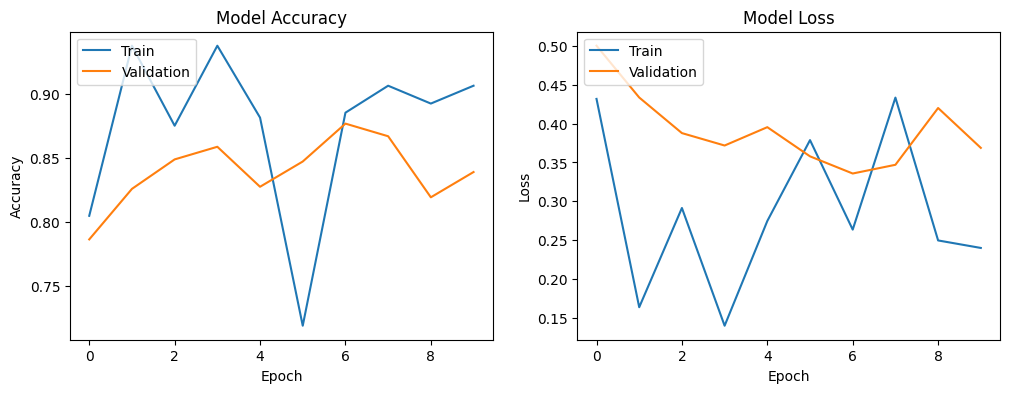

In [20]:
# prompt: # Apply augmentation

import matplotlib.pyplot as plt
import numpy as np
# The model is already trained in the preceding code.
# The next logical step would be to evaluate the model or visualize the training history.

# Evaluate the model on the test set
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history (optional but recommended)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# You can also make predictions on the test set
# predictions = model.predict(test_generator)
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = test_generator.classes

# print("\nPredictions made on the test set.")
# For further analysis like confusion matrix, you would need to import sklearn metrics
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(true_classes, predicted_classes, target_names=class_names))
# print(confusion_matrix(true_classes, predicted_classes))

In [25]:
# prompt: # Test

# Test the function
string1 = "Hello World"
string2 = "lo"
result = remove_dirty_chars(string1, string2)
print(f"Original string: {string1}")
print(f"Characters to remove: {string2}")
print(f"Result after removing characters: {result}")

string1 = "geeksforgeeks"
string2 = "mask"
result = remove_dirty_chars(string1, string2)
print(f"\nOriginal string: {string1}")
print(f"Characters to remove: {string2}")
print(f"Result after removing characters: {result}")


Original string: Hello World
Characters to remove: lo
Result after removing characters: He Wrd

Original string: geeksforgeeks
Characters to remove: mask
Result after removing characters: geeforgee


In [24]:
def remove_dirty_chars(string1, string2):
  """
  Removes characters from string1 that are present in string2.

  Args:
    string1: The string to remove characters from.
    string2: The string containing characters to remove.

  Returns:
    A new string with characters from string2 removed from string1.
  """
  # Create a set of characters to remove for efficient lookup
  chars_to_remove = set(string2)

  # Build the new string by including only characters not in the set
  result = [char for char in string1 if char not in chars_to_remove]

  return "".join(result)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,372,162 (131.12 MB)

 Trainable params: 32,114,178 (122.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Training the transfer learning model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8664 - loss: 0.6800

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.8666 - loss: 0.6787 - val_accuracy: 0.8914 - val_loss: 0.2614
Epoch 2/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.8438 - loss: 0.5540

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.8438 - loss: 0.5540 - val_accuracy: 0.8898 - val_loss: 0.2602
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9241 - loss: 0.2089 - val_accuracy: 0.8766 - val_loss: 0.2804
Epoch 4/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.9375 - loss: 0.1441

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.9375 - loss: 0.1441 - val_accuracy: 0.8832 - val_loss: 0.2895
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9327 - loss: 0.1722 - val_accuracy: 0.8882 - val_loss: 0.2672
Epoch 6/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.9688 - loss: 0.0785

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.9688 - loss: 0.0785 - val_accuracy: 0.8914 - val_loss: 0.2699
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9499 - loss: 0.1380 - val_accuracy: 0.8914 - val_loss: 0.2523
Epoch 8/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 4:44 2s/step - accuracy: 0.9375 - loss: 0.1713

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.9375 - loss: 0.1713 - val_accuracy: 0.9046 - val_loss: 0.2341
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.9403 - loss: 0.1456 - val_accuracy: 0.8487 - val_loss: 0.3936
Epoch 10/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.8750 - loss: 0.2161

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 318ms/step - accuracy: 0.8750 - loss: 0.2161 - val_accuracy: 0.8520 - val_loss: 0.3734

Evaluating the transfer learning model on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7351 - loss: 0.6531
Transfer Learning Test Loss: 0.3790
Transfer Learning Test Accuracy: 0.8494


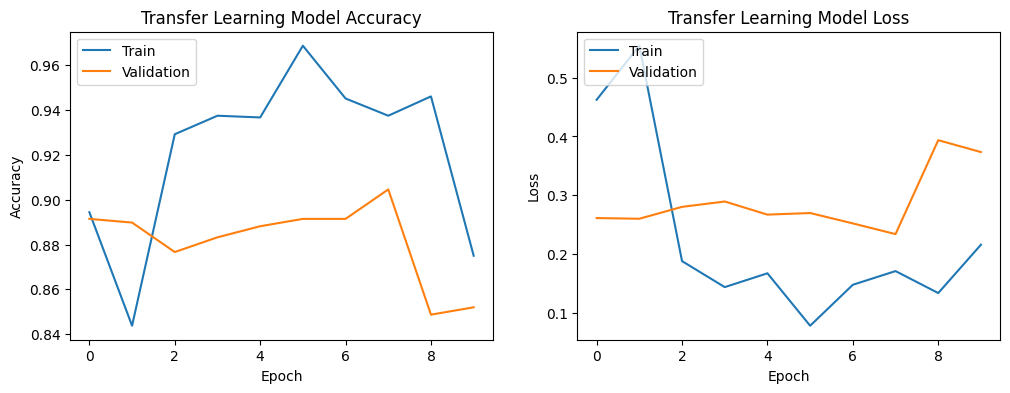

In [28]:
# prompt: # Transfer Learning

import matplotlib.pyplot as plt
# Build a transfer learning model using a pre-trained base
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3),
                                               include_top=False, # Don't include the top classification layer
                                               weights='imagenet') # Use weights from ImageNet pre-training

# Freeze the base model layers
base_model.trainable = False

# Create the new model
transfer_model = Sequential([
    base_model, # Add the pre-trained base model
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax') # Output layer with correct number of classes
])

# Compile the transfer learning model
# Start with a lower learning rate as we are fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print the summary of the transfer learning model
transfer_model.summary()

# Train the transfer learning model
print("\nTraining the transfer learning model...")
transfer_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs, # Using the same number of epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

# Evaluate the transfer learning model on the test set
print("\nEvaluating the transfer learning model on the test set...")
transfer_loss, transfer_accuracy = transfer_model.evaluate(test_generator)

print(f"Transfer Learning Test Loss: {transfer_loss:.4f}")
print(f"Transfer Learning Test Accuracy: {transfer_accuracy:.4f}")

# Plot transfer learning training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'])
plt.plot(transfer_history.history['val_accuracy'])
plt.title('Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'])
plt.plot(transfer_history.history['val_loss'])
plt.title('Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()